In [1]:
COLAB = False
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    DRIVE_PATH = F'/content/gdrive/My Drive/evaluation-pipeline/' # Path to data on Google Drive
    REPO_PATH = F'/content/evaluation-pipeline/'
else:
    DRIVE_PATH = F'' # Local path
    REPO_PATH = ''


#import importlib.util
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
if COLAB:
    !git clone -b development https://github.com/lovis-heindrich/evaluation-pipeline.git

Cloning into 'evaluation-pipeline'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 532 (delta 179), reused 115 (delta 59), pack-reused 249
Receiving objects: 100% (532/532), 192.79 MiB | 21.44 MiB/s, done.
Resolving deltas: 100% (326/326), done.


In [3]:
if COLAB:
    %cd /content/evaluation-pipeline
    !git pull

/content/evaluation-pipeline
Already up to date.


In [4]:
import sys
import torch
from torch import nn
import os.path
from PIL import Image
import torchvision
import numpy as np

# Import local files from github
sys.path.append(REPO_PATH+"src")
import models
import train
import ood
import ood_loader
import utils
from image_transforms import gen_noise_transform, gen_crop_transform, gen_grey_transform, gen_snow_transform, gen_rain_transforms, gen_fog_transform, gen_perspective_transform, gen_blur_transform, gen_rotate_transform, gen_reflection_transform

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Image parameters
num_channels = 3
image_size = 64
num_classes = 14

# Training parameters
batch_size = 128
num_epochs = 5

# GPU
use_gpu = True
device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
print(device)

cuda:0


In [6]:

# Init cure tsd dataset
import cure_tsd_loader
path = DRIVE_PATH+"Data/cure_tsd_64x64.npz"
trainloader, testloader, trainset, testset, dataset = cure_tsd_loader.get_dataloader(path, 0.8, 128)

In [7]:
# Init classifiers
def getBaselineClassifier():
    classifier_baseline = models.BaseClassifier(num_channels, num_classes)
    classifier_baseline.to(device)
    c_loss = nn.CrossEntropyLoss()
    c_baseline_optimizer = torch.optim.Adam(classifier_baseline.parameters(), 0.0002)
    baseline_acc = train.train(classifier_baseline, c_baseline_optimizer, c_loss, 4, trainloader, testloader, device, log=False)
    return classifier_baseline

def getMCClassifier():
    classifier_mc = models.MCSampleClassifier(num_channels, num_classes, 0.6, device)
    classifier_mc.to(device)
    c_loss = nn.CrossEntropyLoss()
    c_mc_optimizer = torch.optim.Adam(classifier_mc.parameters(), 0.0002)
    mc_acc = train.train(classifier_mc, c_mc_optimizer, c_loss, 8, trainloader, testloader, device, log=False)
    return classifier_mc

In [ ]:
if not COLAB:
    if os.path.isfile(DRIVE_PATH+"Data/models/classifier_baseline.pt") and os.path.isfile(DRIVE_PATH+"Data/models/classifier_mc.pt"):
        classifier_baseline = models.BaseClassifier(num_channels, num_classes)
        classifier_mc = models.MCSampleClassifier(num_channels, num_classes, 0.6, device)
        classifier_baseline.load_state_dict(torch.load(DRIVE_PATH+"Data/models/classifier_baseline.pt"))
        classifier_mc.load_state_dict(torch.load(DRIVE_PATH+"Data/models/classifier_mc.pt"))
        classifier_baseline.to(device)
        classifier_mc.to(device)
    else:
        print("Baseline")
        classifier_baseline = getBaselineClassifier()
        print("\nMC Dropout")
        classifier_mc = getMCClassifier()
        torch.save(classifier_baseline.state_dict(), DRIVE_PATH+"Data/models/classifier_baseline.pt")
        torch.save(classifier_mc.state_dict(), DRIVE_PATH+"Data/models/classifier_mc.pt")

    print(train.test(classifier_baseline, testloader, device)[0])
    print(train.test(classifier_mc, testloader, device)[0])

    del classifier_baseline, classifier_mc

In [8]:
pipeline = ood.OodPipeline(1, testset, device)

ood_label = pipeline.get_ood_label()

pipeline_loader = ood_loader.OodLoader(num_channels, image_size, ood_label, device)

In [9]:
def show_images(dataloader, n=8):
    for i, data in enumerate(dataloader):
        x, y = data[0].to(device), data[1].to(device)
        utils.gridshow(x[:n,:,:,:])
        break

In [ ]:
tiny_imagenet_path = (DRIVE_PATH+"Data/tiny-imagenet-val.zip").replace(' ','\ ')
dest_path = (REPO_PATH+"data/").replace(' ','\ ')

if COLAB:
    !unzip -n -q {tiny_imagenet_path}
    tiny_imagenet_data_path = "tiny-imagenet-val/val"
else: 
    !unzip -n -q {tiny_imagenet_path} -d {dest_path}
    tiny_imagenet_data_path = "data/tiny-imagenet-val/val"
#    !unzip -n -q gdrive/My\ Drive/thesis/Data/tiny-imagenet-val.zip

### Standard Pipeline



In [ ]:
noise_uniform_data = pipeline_loader.get_noise_dataset(uniform = True)
noise_normal_data = pipeline_loader.get_noise_dataset(uniform = False)
image_data = pipeline_loader.get_tiny_imagenet_dataset(tiny_imagenet_data_path)
#gan_data = pipeline_loader.get_stored_tensor_dataset(DRIVE_PATH+"Data/lee_gan/lee_10_epoch.p")
#ad_ensemble_data = pipeline_loader.get_stored_tensor_dataset(DRIVE_PATH+"Data/adversarial_noise_ensemble.p")
shuffle_data = pipeline_loader.get_shuffle_dataset(dataset)
mix_data = pipeline_loader.get_mix_dataset(dataset)
swirl_data = pipeline_loader.get_swirl_dataset(dataset)
color_shift_data = pipeline_loader.get_color_shift_dataset(dataset)

In [ ]:
noise_uniform_subset, noise_uniform_dl = pipeline.gen_ood_data(noise_uniform_data) 
noise_normal_subset, noise_normal_dl = pipeline.gen_ood_data(noise_normal_data)
ood_subset, ood_dl = pipeline.gen_ood_data(image_data)
#gan_subset, gan_dl = pipeline.gen_ood_data(gan_data)
#ad_ensemble_subset, ad_ensemble_dl = pipeline.gen_ood_data(ad_ensemble_data)
shuffle_subset, shuffle_dl = pipeline.gen_ood_data(shuffle_data)
mix_subset, mix_dl = pipeline.gen_ood_data(mix_data)
swirl_subset, swirl_dl = pipeline.gen_ood_data(swirl_data)
color_shift_subset, color_shift_dl = pipeline.gen_ood_data(color_shift_data)

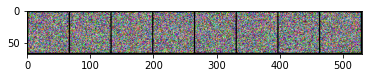

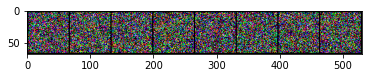

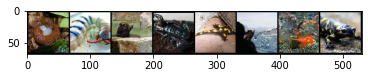

torch.Size([24, 3, 64, 64])


In [ ]:
# Create visualizations
def show_subset(subset):
    dl = torch.utils.data.DataLoader(subset, 8)
    for i, data in enumerate(dl):
        utils.gridshow(data[0])
        return data[0]
        break

imgs = []

imgs.append(show_subset(noise_uniform_subset))
imgs.append(show_subset(noise_normal_subset))
imgs.append(show_subset(ood_subset))

imgs = torch.cat(imgs)
print(imgs.shape)
imgs = torchvision.utils.make_grid(imgs, 8)
torchvision.utils.save_image(imgs, DRIVE_PATH + "Images_thesis/ood_literature.png")

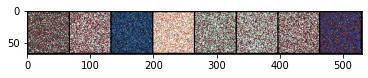

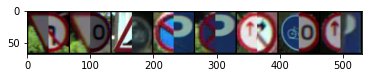

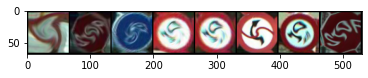

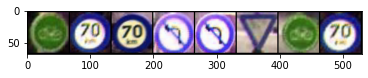

torch.Size([32, 3, 64, 64])


In [ ]:
imgs = []

imgs.append(show_subset(shuffle_subset))
imgs.append(show_subset(mix_subset))
imgs.append(show_subset(swirl_subset))
imgs.append(show_subset(color_shift_subset))

imgs = torch.cat(imgs)
print(imgs.shape)
imgs = torchvision.utils.make_grid(imgs, 8)
torchvision.utils.save_image(imgs, DRIVE_PATH + "Images_thesis/ood_basic.png")

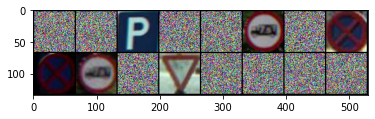

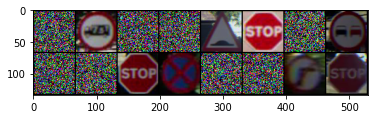

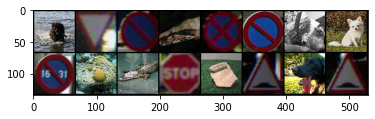

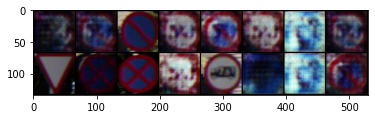

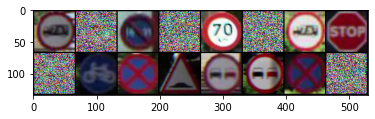

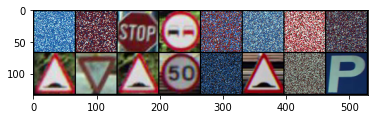

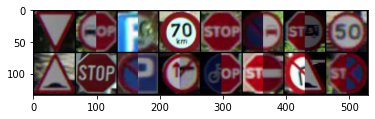

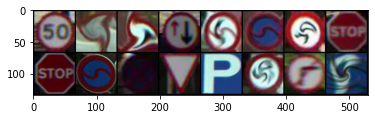

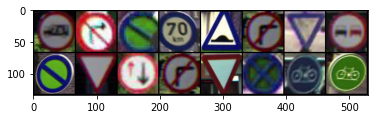

In [ ]:
show_images(noise_uniform_dl, 16)
show_images(noise_normal_dl, 16)
show_images(ood_dl, 16)
show_images(gan_dl, 16)
show_images(ad_ensemble_dl, 16)
show_images(shuffle_dl, 16)
show_images(mix_dl, 16)
show_images(swirl_dl, 16)
show_images(color_shift_dl, 16)

In [ ]:
challenge_data = [ood.ChallengeDataset(noise_uniform_data, "Uniform noise"),
                  ood.ChallengeDataset(noise_normal_data, "Normal noise"),
                  ood.ChallengeDataset(image_data, "Tiny ImageNet"),
                  ood.ChallengeDataset(shuffle_data, "Shuffled images"),
                  ood.ChallengeDataset(mix_data, "Mixed images"),
                  ood.ChallengeDataset(swirl_data, "Swirled images"),
                  ood.ChallengeDataset(color_shift_data, "Color swap")]

In [ ]:
res_baseline, raw_baseline = pipeline.full_evaluation(getBaselineClassifier, challenge_data, 20)

In [ ]:
res_mc, raw_mc = pipeline.full_evaluation(getMCClassifier, challenge_data, 20)

In [ ]:
print(len(raw_baseline))
print(len(raw_mc))
print(len(raw_baseline[0][0]))
print(len(raw_mc[0][0]))
print(raw_baseline[0])
print(raw_mc[0])

7
7
20
20
([{'ROC': 0.992763597138074, 'PR IN': 0.9956805921042937, 'PR OUT': 0.9754026572549408, 'MEAN REAL': 0.9833933115005493, 'MEAN FAKE': 0.4943002760410309}, {'ROC': 0.9849616848692603, 'PR IN': 0.9912681266695142, 'PR OUT': 0.9533254538829172, 'MEAN REAL': 0.9845340251922607, 'MEAN FAKE': 0.6803752779960632}, {'ROC': 0.9934496198381695, 'PR IN': 0.9961777714807346, 'PR OUT': 0.9822340672922791, 'MEAN REAL': 0.9819723963737488, 'MEAN FAKE': 0.42566046118736267}, {'ROC': 0.9759941879583865, 'PR IN': 0.9862743322728278, 'PR OUT': 0.9258268899367366, 'MEAN REAL': 0.9846316576004028, 'MEAN FAKE': 0.8246048092842102}, {'ROC': 0.9846069958745216, 'PR IN': 0.9909341079028602, 'PR OUT': 0.9513850539449376, 'MEAN REAL': 0.9821812510490417, 'MEAN FAKE': 0.6773589253425598}, {'ROC': 0.9981564891581632, 'PR IN': 0.9987384380811021, 'PR OUT': 0.9970705912125937, 'MEAN REAL': 0.9847507476806641, 'MEAN FAKE': 0.3236274719238281}, {'ROC': 0.9941368881536989, 'PR IN': 0.9967239645628307, 'PR OUT

In [ ]:
res = (res_baseline, res_mc)
res_path = DRIVE_PATH + 'Results/Ood_results_final.p'
utils.save_results(res, res_path)

In [10]:
import pandas as pd

def make_raw_df(raw_res, classifier):
    df = pd.DataFrame(columns = ["ROC", "Measure", "Classifier"])
    for res in raw_res:
        for run in res[0]:
            df = df.append({"ROC": run["ROC"], "Measure": res[1], "Classifier": classifier}, ignore_index=True)
    return df

In [ ]:
df_baseline = make_raw_df(raw_baseline, "Baseline")
df_mc = make_raw_df(raw_mc, "MC Dropout")

df = pd.concat([df_baseline, df_mc], axis=0)
res_path = DRIVE_PATH + 'Results/Ood_results_raw_final.p'
utils.save_results(df, res_path)
df

,ROC,Measure,Classifier
0,0.992764,Uniform noise,Baseline
1,0.984962,Uniform noise,Baseline
2,0.993450,Uniform noise,Baseline
3,0.975994,Uniform noise,Baseline
4,0.984607,Uniform noise,Baseline
...,...,...,...
135,0.903575,Color swap,MC Dropout
136,0.798463,Color swap,MC Dropout
137,0.925030,Color swap,MC Dropout
138,0.870467,Color swap,MC Dropout


In [ ]:
df.to_csv(DRIVE_PATH + 'Results/Ood_results_raw_final.csv')

### OOD Image transformations on TinyImagenet

In [ ]:
snow_path = REPO_PATH+"res/snow1.jpg"
snow_img = Image.open(snow_path)
rain_path = REPO_PATH+"res/rain3.jpg"
rain_img = Image.open(rain_path)

#noise = gen_noise_transform(0.8)
#grey = gen_grey_transform(1)
#snow = gen_snow_transform(3, 1.5, snow_img)
#rain = gen_rain_transforms(3, 0.5, 30, rain_img)
#fog = gen_fog_transform(0.9)
#perspective = gen_perspective_transform(0.6, 0.7)
#blur = gen_blur_transform(3.5)
#rotate = gen_rotate_transform(30, 56)
#reflection = gen_reflection_transform(20, 1.3)
#ood_subset_rotate, ood_dl_rotate = pipeline.gen_transformed_ood_data(image_data, rotate)
#show_images(ood_dl_rotate, 16)

# NEW VERSIOn
noise = gen_noise_transform(0.5)
grey = gen_grey_transform(1)
snow = gen_snow_transform([1.5,1.5,1.5], snow_img)
rain = gen_rain_transforms([0.5, 0.4, 0.2], 30, rain_img)
fog = gen_fog_transform(0.7)
perspective = gen_perspective_transform(0.6, 0.7)
blur = gen_blur_transform(3.5)
rotate = gen_rotate_transform(30)
crop = gen_crop_transform(54)
reflection = gen_reflection_transform(24, 1)

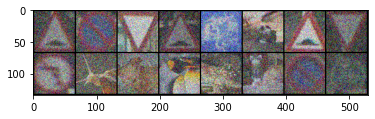

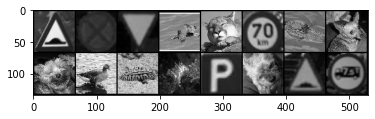

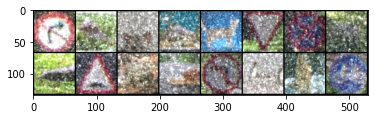

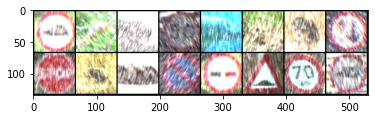

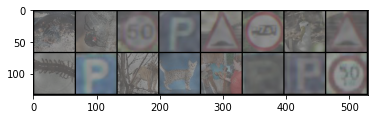

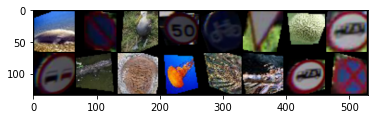

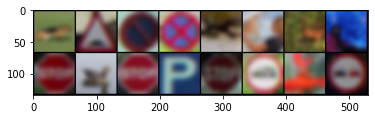

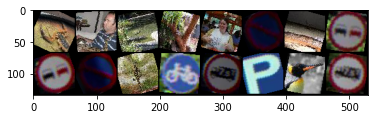

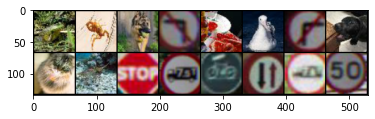

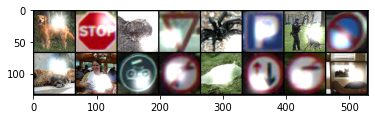

In [ ]:
transforms = [noise, grey, snow, rain, fog, perspective, blur, rotate, crop, reflection]
names = ["Noise", "Grey", "Snow", "Rain", "Fog", "Perspective", "Blur", "Rotate", "Crop", "Reflection"]

transform_dl = [pipeline.gen_transformed_ood_data(image_data, t)[1] for t in transforms]

for i in range(len(transforms)):
    show_images(transform_dl[i], 16)

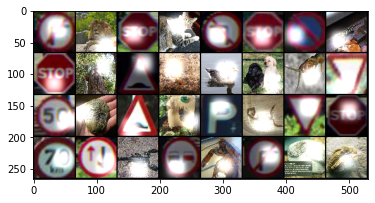

torch.Size([32, 3, 64, 64])


In [ ]:
# Create visualization
for i, data in enumerate(transform_dl[-1]):
        utils.gridshow(data[0][0:32])
        img = data[0][0:32]
        break

print(img.shape)
imgs = torchvision.utils.make_grid(img, 8)
torchvision.utils.save_image(imgs, DRIVE_PATH + "Images_thesis/ood_transformation.png")

In [ ]:
challenge_data_transform = [ood.ChallengeDataset(image_data, name, transform) for name, transform in zip(names, transforms)]
challenge_data_transform.insert(0, ood.ChallengeDataset(image_data, "None"))

In [ ]:
res_baseline_transform, raw_baseline_transform = pipeline.full_evaluation(getBaselineClassifier, challenge_data_transform, 20)

In [ ]:
res = (res_baseline_transform, raw_baseline_transform)
res_path = DRIVE_PATH + 'Results/Ood_results_transform_baseline_tmp.p'
utils.save_results(res, res_path)

In [ ]:
res_mc_transform, raw_mc_transform = pipeline.full_evaluation(getMCClassifier, challenge_data_transform, 20)

In [ ]:
res = (res_baseline_transform, res_mc_transform)
res_path = DRIVE_PATH + 'Results/Ood_results_transform_final.p'
utils.save_results(res, res_path)

In [ ]:
df_baseline = make_raw_df(raw_baseline_transform, "Baseline")
df_mc = make_raw_df(raw_mc_transform, "MC Dropout")

df = pd.concat([df_baseline, df_mc], axis=0)
res_path = DRIVE_PATH + 'Results/Ood_results_transform_raw_final.p'
utils.save_results(df, res_path)
df

,ROC,Measure,Classifier
0,0.944542,None,Baseline
1,0.951640,None,Baseline
2,0.946299,None,Baseline
3,0.948592,None,Baseline
4,0.960725,None,Baseline
...,...,...,...
215,0.787693,Reflection,MC Dropout
216,0.792126,Reflection,MC Dropout
217,0.758366,Reflection,MC Dropout
218,0.813573,Reflection,MC Dropout


In [ ]:
df.to_csv(DRIVE_PATH + 'Results/Ood_results_transform_raw_final.csv')

### GAN Pipeline

In [ ]:
sricharan_wgan_c = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/sricharan_wgan_conditional.pt")
sricharan_gan_c = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/sricharan_gan_conditional.pt")
sricharan_wgan = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/sricharan_wgan.pt")
sricharan_gan = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/sricharan_gan.pt")
lee_wgan_c = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/lee_wgan_conditional.pt")
lee_gan_c = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/lee_gan_conditional.pt")

In [ ]:
challenge_data = [ood.ChallengeDataset(None, "Sricharan WGAN conditional", generator=sricharan_wgan_c, gan=True),
                  ood.ChallengeDataset(None, "Sricharan GAN conditional", generator=sricharan_gan_c, gan=True),
                  ood.ChallengeDataset(None, "Sricharan WGAN", generator=sricharan_wgan, gan=True),
                  ood.ChallengeDataset(None, "Sricharan GAN", generator=sricharan_gan, gan=True),
                  ood.ChallengeDataset(None, "Lee WGAN conditional", generator=lee_wgan_c, gan=True),
                  ood.ChallengeDataset(None, "Lee GAN conditional", generator=lee_gan_c, gan=True)
                  ]

In [ ]:
res_baseline = pipeline.full_evaluation(getBaselineClassifier, challenge_data, 20)
res_baseline[0]

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                              mean     std    mean  ...       std      mean     std
Sricharan WGAN conditional  0.6742  0.2740  0.8013  ...     0.003    0.9355  0.1319
Sricharan GAN conditional   0.9731  0.0349  0.9862  ...     0.003    0.6991  0.1869
Sricharan WGAN              0.9257  0.1185  0.9592  ...     0.003    0.7757  0.1800
Sricharan GAN               0.9906  0.0074  0.9952  ...     0.003    0.5124  0.1720
Lee WGAN conditional        0.9276  0.0295  0.9352  ...     0.003    0.7823  0.0422
Lee GAN conditional         0.8556  0.0371  0.8301  ...     0.003    0.8361  0.0341

[6 rows x 10 columns]

In [ ]:
res_mc = pipeline.full_evaluation(getMCClassifier, challenge_data, 20)
res_mc[0]

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                              mean     std    mean  ...       std      mean     std
Sricharan WGAN conditional  0.9579  0.0309  0.9756  ...    0.0085    0.5842  0.1261
Sricharan GAN conditional   0.9891  0.0045  0.9939  ...    0.0087    0.3460  0.0665
Sricharan WGAN              0.9766  0.0136  0.9869  ...    0.0086    0.4812  0.1029
Sricharan GAN               0.9902  0.0045  0.9945  ...    0.0087    0.3295  0.0785
Lee WGAN conditional        0.9377  0.0109  0.9410  ...    0.0086    0.5183  0.0239
Lee GAN conditional         0.8838  0.0144  0.8181  ...    0.0088    0.6067  0.0266

[6 rows x 10 columns]

In [ ]:
res = (res_baseline[0], res_mc[0])
res_path = DRIVE_PATH + 'Results/Ood_results_gan.p'
utils.save_results(res, res_path)

### Images for gans

In [ ]:
def generate_images(path, name, save_path, n=10):
    gans = [pipeline_loader.get_gan(path + name +str(i+1)+".pt") for i in range(n)]
    for i, gan in enumerate(gans):
        img = gan.get_gan_images()
        torchvision.utils.save_image(img, save_path + name +str(i+1)+".png")

generate_images(DRIVE_PATH+"Data/models/gan/", "lee_gan_conditional_", DRIVE_PATH+"Data/models/gan/images/")
generate_images(DRIVE_PATH+"Data/models/gan/", "lee_wgan_conditional", DRIVE_PATH+"Data/models/gan/images/")
generate_images(DRIVE_PATH+"Data/models/gan/", "sricharan_gan_conditional", DRIVE_PATH+"Data/models/gan/images/")
generate_images(DRIVE_PATH+"Data/models/gan/", "sricharan_wgan_conditional", DRIVE_PATH+"Data/models/gan/images/")
generate_images(DRIVE_PATH+"Data/models/gan/", "sricharan_wgan_conditional", DRIVE_PATH+"Data/models/gan/images/")
generate_images(DRIVE_PATH+"Data/models/gan/", "sricharan_wgan_002_conditional", DRIVE_PATH+"Data/models/gan/images/")
generate_images(DRIVE_PATH+"Data/models/gan/", "sricharan_wgan_2e_conditional", DRIVE_PATH+"Data/models/gan/images/")

### Lee GAN conditional

In [ ]:
gans = [pipeline_loader.get_gan(DRIVE_PATH+"Data/models/gan/lee_gan_conditional_"+str(i+1)+".pt") for i in range(10)]
challenge_data = [ood.ChallengeDataset(None, "Lee Gan conditional " + str(i), generator=gan, gan=True) for i, gan in enumerate(gans)]

In [ ]:
res_lee_gan_baseline, raw_lee_gan_baseline = pipeline.full_evaluation(getBaselineClassifier, challenge_data, 20)
res_lee_gan_baseline

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                         mean     std    mean  ...       std      mean     std
Lee Gan conditional 0  0.8873  0.0271  0.8710  ...     0.003    0.8030  0.0557
Lee Gan conditional 1  0.8450  0.0632  0.8541  ...     0.003    0.8626  0.0496
Lee Gan conditional 2  0.8347  0.0390  0.7926  ...     0.003    0.7895  0.0614
Lee Gan conditional 3  0.8391  0.0597  0.8249  ...     0.003    0.7997  0.0696
Lee Gan conditional 4  0.9048  0.0349  0.9072  ...     0.003    0.8048  0.0691
Lee Gan conditional 5  0.8469  0.0340  0.8156  ...     0.003    0.8043  0.0258
Lee Gan conditional 6  0.8562  0.0451  0.8522  ...     0.003    0.8214  0.0392
Lee Gan conditional 7  0.7601  0.0592  0.7606  ...     0.003    0.8963  0.0302
Lee Gan conditional 8  0.8995  0.0412  0.9038  ...     0.003    0.8276  0.0493
Lee Gan conditional 9  0.9055  0.0190  0.8758  ...     0.003    0.7273  0.0471

[10 rows x 10 columns]

In [ ]:
res_lee_gan_mc, raw_lee_gan_mc = pipeline.full_evaluation(getMCClassifier, challenge_data, 20)
res_lee_gan_mc

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                         mean     std    mean  ...       std      mean     std
Lee Gan conditional 0  0.9069  0.0114  0.8776  ...    0.0085    0.6216  0.0286
Lee Gan conditional 1  0.8863  0.0160  0.8758  ...    0.0084    0.6521  0.0300
Lee Gan conditional 2  0.8665  0.0185  0.8169  ...    0.0084    0.6487  0.0285
Lee Gan conditional 3  0.8876  0.0157  0.8523  ...    0.0083    0.5993  0.0416
Lee Gan conditional 4  0.9250  0.0128  0.9297  ...    0.0081    0.5969  0.0300
Lee Gan conditional 5  0.8584  0.0148  0.8310  ...    0.0083    0.6185  0.0162
Lee Gan conditional 6  0.9015  0.0163  0.8940  ...    0.0080    0.5915  0.0261
Lee Gan conditional 7  0.8177  0.0198  0.7778  ...    0.0080    0.7091  0.0233
Lee Gan conditional 8  0.9158  0.0162  0.9196  ...    0.0082    0.6231  0.0365
Lee Gan conditional 9  0.8976  0.0108  0.8355  ...    0.0080    0.5600  0.0313

[10 rows x 10 columns]

In [ ]:
res = (res_lee_gan_baseline, res_lee_gan_mc)
res_path = DRIVE_PATH + 'Results/Ood_results_lee_gan_final.p'
utils.save_results(res, res_path)

In [ ]:
df_baseline = make_raw_df(raw_lee_gan_baseline, "Baseline")
df_mc = make_raw_df(raw_lee_gan_mc, "MC Dropout")

df = pd.concat([df_baseline, df_mc], axis=0)
res_path = DRIVE_PATH + 'Results/Ood_results_lee_gan_raw_final.p'
utils.save_results(df, res_path)

df["Measure"] = "Lee GAN conditional"
df.to_csv(DRIVE_PATH + 'Results/Ood_results_lee_gan_raw_final.csv')
lee_gan_conditional_df = df
lee_gan_conditional_df

,ROC,Measure,Classifier
0,0.875475,Lee GAN conditional,Baseline
1,0.910689,Lee GAN conditional,Baseline
2,0.859769,Lee GAN conditional,Baseline
3,0.894704,Lee GAN conditional,Baseline
4,0.885496,Lee GAN conditional,Baseline
...,...,...,...
195,0.889920,Lee GAN conditional,MC Dropout
196,0.905037,Lee GAN conditional,MC Dropout
197,0.886815,Lee GAN conditional,MC Dropout
198,0.883814,Lee GAN conditional,MC Dropout


### Lee WGan conditional

In [ ]:
gans = [pipeline_loader.get_gan(DRIVE_PATH+"Data/models/gan/lee_wgan_conditional"+str(i+1)+".pt") for i in range(10)]
challenge_data = [ood.ChallengeDataset(None, "Lee WGan conditional " + str(i), generator=gan, gan=True) for i, gan in enumerate(gans)]

In [ ]:
res_lee_wgan_baseline, raw_lee_wgan_baseline = pipeline.full_evaluation(getBaselineClassifier, challenge_data, 20)
res_lee_wgan_baseline

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                          mean     std    mean  ...       std      mean     std
Lee WGan conditional 0  0.8876  0.0329  0.8686  ...    0.0045    0.7590  0.0492
Lee WGan conditional 1  0.9086  0.0222  0.9048  ...    0.0045    0.7544  0.0465
Lee WGan conditional 2  0.8983  0.0279  0.8831  ...    0.0045    0.7928  0.0325
Lee WGan conditional 3  0.7462  0.0942  0.7474  ...    0.0045    0.9202  0.0489
Lee WGan conditional 4  0.9026  0.0321  0.8830  ...    0.0045    0.8039  0.0256
Lee WGan conditional 5  0.9078  0.0324  0.9140  ...    0.0045    0.8085  0.0252
Lee WGan conditional 6  0.7918  0.0357  0.7660  ...    0.0045    0.8454  0.0187
Lee WGan conditional 7  0.9129  0.0375  0.9068  ...    0.0045    0.7613  0.0380
Lee WGan conditional 8  0.8751  0.0423  0.8756  ...    0.0045    0.8482  0.0329
Lee WGan conditional 9  0.8353  0.0554  0.8444  ...    0.0045    0.8695  0.0289

[10 rows x 10 columns]

In [ ]:
res_lee_wgan_mc, raw_lee_wgan_mc = pipeline.full_evaluation(getMCClassifier, challenge_data, 20)
res_lee_wgan_mc

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                          mean     std    mean  ...       std      mean     std
Lee WGan conditional 0  0.8840  0.0096  0.8550  ...    0.0086    0.5918  0.0230
Lee WGan conditional 1  0.9200  0.0108  0.9135  ...    0.0088    0.5497  0.0216
Lee WGan conditional 2  0.8849  0.0152  0.8666  ...    0.0086    0.6450  0.0230
Lee WGan conditional 3  0.8250  0.0335  0.8547  ...    0.0085    0.7665  0.0297
Lee WGan conditional 4  0.9239  0.0100  0.9299  ...    0.0086    0.5970  0.0228
Lee WGan conditional 5  0.9286  0.0100  0.9369  ...    0.0086    0.5845  0.0236
Lee WGan conditional 6  0.7814  0.0142  0.7222  ...    0.0085    0.6993  0.0217
Lee WGan conditional 7  0.9024  0.0114  0.8638  ...    0.0086    0.5530  0.0241
Lee WGan conditional 8  0.8675  0.0116  0.8447  ...    0.0089    0.6621  0.0312
Lee WGan conditional 9  0.8653  0.0136  0.8475  ...    0.0087    0.6659  0.0285

[10 rows x 10 columns]

In [ ]:
res = (res_lee_wgan_baseline, res_lee_wgan_mc)
res_path = DRIVE_PATH + 'Results/Ood_results_lee_wgan_final.p'
utils.save_results(res, res_path)

In [ ]:
df_baseline = make_raw_df(raw_lee_wgan_baseline, "Baseline")
df_mc = make_raw_df(raw_lee_wgan_mc, "MC Dropout")

df = pd.concat([df_baseline, df_mc], axis=0)
res_path = DRIVE_PATH + 'Results/Ood_results_lee_wgan_raw_final.p'
utils.save_results(df, res_path)

df["Measure"] = "Lee WGAN conditional"
df.to_csv(DRIVE_PATH + 'Results/Ood_results_lee_wgan_raw_final.csv')
lee_wgan_conditional_df = df
lee_wgan_conditional_df

,ROC,Measure,Classifier
0,0.874782,Lee WGAN conditional,Baseline
1,0.871126,Lee WGAN conditional,Baseline
2,0.909013,Lee WGAN conditional,Baseline
3,0.930169,Lee WGAN conditional,Baseline
4,0.905668,Lee WGAN conditional,Baseline
...,...,...,...
195,0.877000,Lee WGAN conditional,MC Dropout
196,0.857565,Lee WGAN conditional,MC Dropout
197,0.851539,Lee WGAN conditional,MC Dropout
198,0.844262,Lee WGAN conditional,MC Dropout


### Sricharan GAN

In [11]:
gans = [pipeline_loader.get_gan(DRIVE_PATH+"Data/models/gan/sricharan_gan_conditional"+str(i+1)+".pt") for i in range(10)]
challenge_data = [ood.ChallengeDataset(None, "Sricharan Gan conditional " + str(i), generator=gan, gan=True) for i, gan in enumerate(gans)]

In [12]:
res_sricharan_gan_baseline, raw_sricharan_gan_baseline = pipeline.full_evaluation(getBaselineClassifier, challenge_data, 20)
res_sricharan_gan_baseline

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                               mean     std    mean  ...       std      mean     std
Sricharan Gan conditional 0  0.9871  0.0131  0.9934  ...    0.0045    0.5369  0.1704
Sricharan Gan conditional 1  0.9873  0.0088  0.9935  ...    0.0045    0.5700  0.1429
Sricharan Gan conditional 2  0.9868  0.0095  0.9932  ...    0.0045    0.5705  0.1589
Sricharan Gan conditional 3  0.9892  0.0072  0.9944  ...    0.0045    0.5460  0.1295
Sricharan Gan conditional 4  0.9841  0.0136  0.9919  ...    0.0045    0.6231  0.1691
Sricharan Gan conditional 5  0.9703  0.0459  0.9845  ...    0.0045    0.6966  0.1777
Sricharan Gan conditional 6  0.9873  0.0100  0.9935  ...    0.0045    0.5502  0.1644
Sricharan Gan conditional 7  0.9826  0.0162  0.9911  ...    0.0045    0.6263  0.1798
Sricharan Gan conditional 8  0.9873  0.0089  0.9935  ...    0.0045    0.5677  0.1383
Sricharan Gan conditional 9  0.9870  0.0094  0.9934  ...    0.0045    0.5718  0.1892

[10 rows x 10 columns]

In [13]:
res_sricharan_gan_mc, raw_sricharan_gan_mc = pipeline.full_evaluation(getMCClassifier, challenge_data, 20)
res_sricharan_gan_mc

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                               mean     std    mean  ...       std      mean     std
Sricharan Gan conditional 0  0.9883  0.0061  0.9935  ...    0.0086    0.3343  0.0699
Sricharan Gan conditional 1  0.9916  0.0048  0.9953  ...    0.0088    0.2879  0.0635
Sricharan Gan conditional 2  0.9879  0.0067  0.9932  ...    0.0086    0.3412  0.0751
Sricharan Gan conditional 3  0.9900  0.0058  0.9944  ...    0.0085    0.3136  0.0685
Sricharan Gan conditional 4  0.9947  0.0026  0.9969  ...    0.0086    0.2451  0.0385
Sricharan Gan conditional 5  0.9839  0.0060  0.9912  ...    0.0086    0.3910  0.0663
Sricharan Gan conditional 6  0.9909  0.0053  0.9949  ...    0.0085    0.2959  0.0634
Sricharan Gan conditional 7  0.9901  0.0056  0.9944  ...    0.0086    0.3089  0.0649
Sricharan Gan conditional 8  0.9859  0.0078  0.9922  ...    0.0089    0.3647  0.0796
Sricharan Gan conditional 9  0.9899  0.0058  0.9943  ...    0.0087    0.3144  0.0644

[10 rows x 10 columns]

In [14]:
res = (res_sricharan_gan_baseline, res_sricharan_gan_mc)
res_path = DRIVE_PATH + 'Results/Ood_results_sricharan_gan_final.p'
utils.save_results(res, res_path)

In [15]:
df_baseline = make_raw_df(raw_sricharan_gan_baseline, "Baseline")
df_mc = make_raw_df(raw_sricharan_gan_mc, "MC Dropout")

df = pd.concat([df_baseline, df_mc], axis=0)
res_path = DRIVE_PATH + 'Results/Ood_results_sricharan_gan_raw_final.p'
utils.save_results(df, res_path)

df["Measure"] = "Sricharan GAN conditional"
df.to_csv(DRIVE_PATH + 'Results/Ood_results_sricharan_gan_raw_final.csv')
lee_wgan_conditional_df = df
lee_wgan_conditional_df

,ROC,Measure,Classifier
0,0.994155,Sricharan GAN conditional,Baseline
1,0.976543,Sricharan GAN conditional,Baseline
2,0.996487,Sricharan GAN conditional,Baseline
3,0.998700,Sricharan GAN conditional,Baseline
4,0.989815,Sricharan GAN conditional,Baseline
...,...,...,...
195,0.980157,Sricharan GAN conditional,MC Dropout
196,0.994372,Sricharan GAN conditional,MC Dropout
197,0.989737,Sricharan GAN conditional,MC Dropout
198,0.990035,Sricharan GAN conditional,MC Dropout


### Sricharan WGan

In [16]:
gans = [pipeline_loader.get_gan(DRIVE_PATH+"Data/models/gan/sricharan_wgan_conditional"+str(i+1)+".pt") for i in range(10)]
challenge_data = [ood.ChallengeDataset(None, "Sricharan WGan conditional " + str(i), generator=gan, gan=True) for i, gan in enumerate(gans)]

In [17]:
res_sricharan_wgan_baseline, raw_sricharan_wgan_baseline = pipeline.full_evaluation(getBaselineClassifier, challenge_data, 20)
res_sricharan_wgan_baseline

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                                mean     std    mean  ...       std      mean     std
Sricharan WGan conditional 0  0.7688  0.2077  0.8671  ...    0.0022    0.9585  0.0861
Sricharan WGan conditional 1  0.8076  0.2397  0.8860  ...    0.0022    0.8761  0.1588
Sricharan WGan conditional 2  0.9587  0.0492  0.9782  ...    0.0022    0.7662  0.1777
Sricharan WGan conditional 3  0.9820  0.0143  0.9905  ...    0.0022    0.6623  0.1649
Sricharan WGan conditional 4  0.9861  0.0122  0.9927  ...    0.0022    0.5921  0.1861
Sricharan WGan conditional 5  0.9529  0.0708  0.9721  ...    0.0022    0.7386  0.1883
Sricharan WGan conditional 6  0.9255  0.1016  0.9598  ...    0.0022    0.8012  0.1882
Sricharan WGan conditional 7  0.2340  0.2141  0.5014  ...    0.0022    0.9994  0.0012
Sricharan WGan conditional 8  0.9285  0.0622  0.9619  ...    0.0022    0.8644  0.1334
Sricharan WGan conditional 9  0.9362  0.0838  0.9660  ...    0.0022    0.7857  0.1925

[10 rows x 10 columns]

In [18]:
res_sricharan_wgan_mc, raw_sricharan_wgan_mc = pipeline.full_evaluation(getMCClassifier, challenge_data, 20)
res_sricharan_wgan_mc

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                                mean     std    mean  ...       std      mean     std
Sricharan WGan conditional 0  0.9700  0.0125  0.9832  ...    0.0078    0.5149  0.1008
Sricharan WGan conditional 1  0.9705  0.0158  0.9836  ...    0.0081    0.5039  0.0889
Sricharan WGan conditional 2  0.9802  0.0068  0.9890  ...    0.0077    0.4349  0.0638
Sricharan WGan conditional 3  0.9862  0.0045  0.9922  ...    0.0078    0.3683  0.0632
Sricharan WGan conditional 4  0.9851  0.0053  0.9916  ...    0.0079    0.3824  0.0605
Sricharan WGan conditional 5  0.9766  0.0068  0.9869  ...    0.0080    0.4703  0.0535
Sricharan WGan conditional 6  0.9743  0.0144  0.9857  ...    0.0080    0.4732  0.1025
Sricharan WGan conditional 7  0.7467  0.1367  0.8216  ...    0.0080    0.8565  0.0554
Sricharan WGan conditional 8  0.9721  0.0108  0.9845  ...    0.0079    0.5023  0.0904
Sricharan WGan conditional 9  0.9820  0.0150  0.9898  ...    0.0080    0.3897  0.1135

[10 rows x 10 columns]

In [19]:
res = (res_sricharan_wgan_baseline, res_sricharan_wgan_mc)
res_path = DRIVE_PATH + 'Results/Ood_results_sricharan_wgan_final.p'
utils.save_results(res, res_path)

In [20]:
df_baseline = make_raw_df(raw_sricharan_wgan_baseline, "Baseline")
df_mc = make_raw_df(raw_sricharan_wgan_mc, "MC Dropout")

df = pd.concat([df_baseline, df_mc], axis=0)
res_path = DRIVE_PATH + 'Results/Ood_results_sricharan_wgan_raw_final.p'
utils.save_results(df, res_path)

df["Measure"] = "Sricharan WGAN conditional"
df.to_csv(DRIVE_PATH + 'Results/Ood_results_sricharan_wgan_raw_final.csv')
lee_wgan_conditional_df = df
lee_wgan_conditional_df

,ROC,Measure,Classifier
0,0.915831,Sricharan WGAN conditional,Baseline
1,0.969460,Sricharan WGAN conditional,Baseline
2,0.779961,Sricharan WGAN conditional,Baseline
3,0.593771,Sricharan WGAN conditional,Baseline
4,0.845390,Sricharan WGAN conditional,Baseline
...,...,...,...
195,0.987412,Sricharan WGAN conditional,MC Dropout
196,0.980419,Sricharan WGAN conditional,MC Dropout
197,0.985773,Sricharan WGAN conditional,MC Dropout
198,0.988848,Sricharan WGAN conditional,MC Dropout


### Sricharan WGAN stopping 0.002

In [21]:
def gan_pipeline(path, name, res_path, n=20):
    gans = [pipeline_loader.get_gan(DRIVE_PATH+path+str(i+1)+".pt") for i in range(10)]
    challenge_data = [ood.ChallengeDataset(None, name + str(i), generator=gan, gan=True) for i, gan in enumerate(gans)]
    res_baseline, raw_baseline = pipeline.full_evaluation(getBaselineClassifier, challenge_data, n)
    print(res_baseline)
    res_mc, raw_mc = pipeline.full_evaluation(getMCClassifier, challenge_data, n)
    print(res_mc)
    res = (res_baseline, res_mc)
    raw_path =DRIVE_PATH +res_path + "_raw"
    res_path = DRIVE_PATH +res_path + ".p"
    utils.save_results(res, res_path)

    df_baseline = make_raw_df(raw_baseline, "Baseline")
    df_mc = make_raw_df(raw_mc, "MC Dropout")

    df = pd.concat([df_baseline, df_mc], axis=0)
    utils.save_results(df, raw_path + '.p')

    df["Measure"] = name
    df.to_csv(raw_path + '.csv')

In [22]:
gan_pipeline("Data/models/gan/sricharan_wgan_002_conditional", "Sricharan WGan 002 conditional ", 'Results/Ood_results_sricharan_002_wgan_final')


                                     ROC          ... MEAN FAKE        
                                    mean     std  ...      mean     std
Sricharan WGan 002 conditional 0  0.9448  0.0678  ...    0.8198  0.1524
Sricharan WGan 002 conditional 1  0.9233  0.1391  ...    0.8003  0.1609
Sricharan WGan 002 conditional 2  0.9133  0.1349  ...    0.8552  0.1354
Sricharan WGan 002 conditional 3  0.8118  0.2818  ...    0.8773  0.1548
Sricharan WGan 002 conditional 4  0.8242  0.1979  ...    0.8458  0.2084
Sricharan WGan 002 conditional 5  0.8480  0.1750  ...    0.8870  0.1541
Sricharan WGan 002 conditional 6  0.9692  0.0466  ...    0.7041  0.1881
Sricharan WGan 002 conditional 7  0.6469  0.2632  ...    0.9460  0.1213
Sricharan WGan 002 conditional 8  0.9653  0.0772  ...    0.7011  0.1707
Sricharan WGan 002 conditional 9  0.9318  0.1299  ...    0.7529  0.1754

[10 rows x 10 columns]



                                     ROC          ... MEAN FAKE        
                                    mean     std  ...      mean     std
Sricharan WGan 002 conditional 0  0.9861  0.0056  ...    0.3568  0.0596
Sricharan WGan 002 conditional 1  0.9824  0.0069  ...    0.4017  0.0773
Sricharan WGan 002 conditional 2  0.9721  0.0086  ...    0.4992  0.0719
Sricharan WGan 002 conditional 3  0.9705  0.0105  ...    0.5141  0.0779
Sricharan WGan 002 conditional 4  0.9785  0.0091  ...    0.4341  0.0898
Sricharan WGan 002 conditional 5  0.9533  0.0301  ...    0.5955  0.1094
Sricharan WGan 002 conditional 6  0.9823  0.0119  ...    0.3921  0.1033
Sricharan WGan 002 conditional 7  0.9486  0.0326  ...    0.6121  0.1209
Sricharan WGan 002 conditional 8  0.9888  0.0059  ...    0.3228  0.0675
Sricharan WGan 002 conditional 9  0.9796  0.0059  ...    0.4317  0.0639

[10 rows x 10 columns]


In [23]:
gan_pipeline("Data/models/gan/sricharan_wgan_2e_conditional", "Sricharan WGan 2e conditional ", 'Results/Ood_results_sricharan_2e_wgan_final')


                                    ROC          ... MEAN FAKE        
                                   mean     std  ...      mean     std
Sricharan WGan 2e conditional 0  0.4103  0.3391  ...    0.9640  0.0891
Sricharan WGan 2e conditional 1  0.8029  0.2751  ...    0.8807  0.1490
Sricharan WGan 2e conditional 2  0.7914  0.2182  ...    0.9143  0.1125
Sricharan WGan 2e conditional 3  0.9715  0.0372  ...    0.7012  0.1821
Sricharan WGan 2e conditional 4  0.6666  0.2918  ...    0.9360  0.1095
Sricharan WGan 2e conditional 5  0.9327  0.1086  ...    0.7859  0.1685
Sricharan WGan 2e conditional 6  0.2278  0.2116  ...    0.9993  0.0019
Sricharan WGan 2e conditional 7  0.8189  0.2299  ...    0.8806  0.1459
Sricharan WGan 2e conditional 8  0.9325  0.0708  ...    0.8214  0.1733
Sricharan WGan 2e conditional 9  0.9681  0.0433  ...    0.6793  0.2280

[10 rows x 10 columns]



                                    ROC          ... MEAN FAKE        
                                   mean     std  ...      mean     std
Sricharan WGan 2e conditional 0  0.8913  0.0797  ...    0.7408  0.1100
Sricharan WGan 2e conditional 1  0.9642  0.0261  ...    0.5353  0.1207
Sricharan WGan 2e conditional 2  0.9668  0.0162  ...    0.5408  0.0959
Sricharan WGan 2e conditional 3  0.9871  0.0051  ...    0.3548  0.0572
Sricharan WGan 2e conditional 4  0.9388  0.0290  ...    0.6626  0.1178
Sricharan WGan 2e conditional 5  0.9889  0.0050  ...    0.3319  0.0555
Sricharan WGan 2e conditional 6  0.8631  0.0960  ...    0.7659  0.1320
Sricharan WGan 2e conditional 7  0.9789  0.0174  ...    0.4320  0.1179
Sricharan WGan 2e conditional 8  0.9633  0.0192  ...    0.5575  0.0975
Sricharan WGan 2e conditional 9  0.9855  0.0090  ...    0.3697  0.0936

[10 rows x 10 columns]


#### GAN Variance through training check


In [ ]:
sricharan_wgan_c_1 = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/sricharan_wgan_conditional.pt")
sricharan_wgan_c_2 = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/sricharan_wgan_conditional_2.pt")
sricharan_wgan_c_3 = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/sricharan_wgan_conditional_3.pt")
sricharan_wgan_c_4 = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/sricharan_wgan_conditional_4.pt")
sricharan_wgan_c_5 = pipeline_loader.get_gan(DRIVE_PATH+"Data/models/sricharan_wgan_conditional_5.pt")

challenge_data_var = [ood.ChallengeDataset(None, "Sricharan WGAN conditional 1", generator=sricharan_wgan_c_1, gan=True),
                  ood.ChallengeDataset(None, "Sricharan WGAN conditional 2", generator=sricharan_wgan_c_2, gan=True),
                  ood.ChallengeDataset(None, "Sricharan WGAN conditional 3", generator=sricharan_wgan_c_3, gan=True),
                  ood.ChallengeDataset(None, "Sricharan WGAN conditional 4", generator=sricharan_wgan_c_4, gan=True),
                  ood.ChallengeDataset(None, "Sricharan WGAN conditional 5", generator=sricharan_wgan_c_5, gan=True)]

In [ ]:
res_baseline = pipeline.full_evaluation(getBaselineClassifier, challenge_data_var, 20)
res_baseline[0]

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                                mean     std    mean  ...       std      mean     std
Sricharan WGAN conditional 1  0.6756  0.2865  0.8011  ...    0.0019    0.9660  0.0778
Sricharan WGAN conditional 2  0.7693  0.2544  0.8567  ...    0.0019    0.9048  0.1330
Sricharan WGAN conditional 3  0.6280  0.2286  0.7821  ...    0.0019    0.9853  0.0325
Sricharan WGAN conditional 4  0.9171  0.1115  0.9544  ...    0.0019    0.8555  0.1606
Sricharan WGAN conditional 5  0.8506  0.1400  0.9137  ...    0.0019    0.9365  0.0949

[5 rows x 10 columns]

In [ ]:
res_mc = pipeline.full_evaluation(getMCClassifier, challenge_data_var, 20)
res_mc[0]

ROC           PR IN  ... MEAN REAL MEAN FAKE        
                                mean     std    mean  ...       std      mean     std
Sricharan WGAN conditional 1  0.8179  0.2472  0.8891  ...    0.0383    0.7785  0.2122
Sricharan WGAN conditional 2  0.8562  0.1996  0.9116  ...    0.0383    0.7869  0.1634
Sricharan WGAN conditional 3  0.7898  0.2293  0.8772  ...    0.0382    0.8143  0.1850
Sricharan WGAN conditional 4  0.9496  0.0848  0.9722  ...    0.0383    0.6480  0.2468
Sricharan WGAN conditional 5  0.9137  0.1180  0.9502  ...    0.0383    0.6968  0.2669

[5 rows x 10 columns]

In [ ]:
res = (res_baseline[0], res_mc[0])
res_path = DRIVE_PATH + 'Results/Ood_results_gan_var.p'
utils.save_results(res, res_path)

In [ ]:
#sricharan_subset, sricharan_dl = pipeline.gen_ood_data(sricharan_data)
#lee_subset, lee_dl = pipeline.gen_ood_data(lee_data)

#show_images(sricharan_dl, 16)
#show_images(lee_dl, 16)